In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import utility.df
import utility.iolib
import utility.plotlib
from utility.feature import Feature, FeatureCM

#env = sys.argv[1] if len(sys.argv) > 2 else "dev"

In [2]:
# Setup configuration
cfg = config.ResearchConfig
time_format = cfg.CSV_TIME_FORMAT
date_format = cfg.CSV_DATE_FORMAT
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)

# Retrieve data
df_subspt, df_lesson, df_incomp, df_crclum, df_pupils = utility.iolib.retrieve_data(cfg)
print("Complete loading data for subscription and lesson history!")

Complete loading data for subscription and lesson history!


In [3]:
# Filter data
cutoff_date = pd.to_datetime(cfg.CUTOFF_DATE, format=cfg.CSV_DATE_FORMAT)
first_date_impFromData = df_subspt.subscription_start_date.min()

pupils_toBeRemoved = utility.df.filter_subspt_data(
    df_subspt, first_date_impFromData, cutoff_date, remove_annual_subspt=False)
df_lesson1 = df_lesson[~df_lesson['pupilId'].isin(pupils_toBeRemoved)]
df_incomp1 = df_incomp[~df_incomp['pupilId'].isin(pupils_toBeRemoved)]
df_subspt1 = df_subspt[~df_subspt['pupilId'].isin(pupils_toBeRemoved)]

df_subspt1 = utility.df.compute_customer_month(df_subspt1, cfg)

# Construct dates frame
df_datesFrame = utility.df.construct_dates_frame(df_subspt1, df_lesson1, df_incomp1, cfg)

By the cutoff date 2018-04-20, there are 1234 active subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to know the lifetime of their subscriptions. 

In the first month of dataset starting from 2014-01-01, there are 154 renewal or new subscriptions.
These subscribers shall be removed from the analysis because we have no evidence to show if they renewed or newly joined. 

In summary, there are 1380/5685 subscribers being removed from the dataset in the analysis. 

Calculate customer month in the subscription table.


100%|██████████| 4305/4305 [00:06<00:00, 694.91it/s] 


Construct data-driven dates frame.
The dates frame has already been assigned customer month and saved in a file. The file has been loaded!


# Features

In [4]:
# Initialise feature obj
ftr = Feature(df_datesFrame)

ftr.add_usageTime(df_lesson1, df_incomp1)
ftr.add_progressions(df_lesson1)
ftr.add_age(df_pupils)
ftr.add_outcome(df_lesson1)

ftr.df_features_.head()

+ Add feature: usage time.
+ Add feature: progressions.
+ Add feature: pupils' age.
+ Add feature: outcome.


count_complete  count_incomplete  customer_month  \
pupilId date                                                           
655886  2014-04-18             2.0               0.0             0.0   
        2014-04-19             1.0               0.0             0.0   
        2014-04-20             2.0               0.0             0.0   
        2014-04-21             3.0               0.0             0.0   
        2014-05-18             5.0               0.0             0.0   

                    time_taken_complete  time_taken_incomplete  progressions  \
pupilId date                                                                   
655886  2014-04-18                431.0                    0.0           0.0   
        2014-04-19                323.0                    0.0           1.0   
        2014-04-20                744.0                    0.0           1.0   
        2014-04-21               1281.0                    0.0           2.0   
        2014-05-18               1806.0                    0.0           3.0   

                    progressions_delta       age  num_fwrd  num_pass  \
pupilId date                                                           
655886  2014-04-18                 0.0  5.059548       0.0       2.0   
        2014-04-19                 1.0  5.062286       0.0       1.0   
        2014-04-20                 0.0  5.065024       0.0       0.0   
        2014-04-21                 1.0  5.067762       0.0       2.0   
        2014-05-18                 1.0  5.141684       0.0       3.0   

                    num_stat  num_fail  num_back  num_repl  num_attempt  \
pupilId date                                                              
655886  2014-04-18       0.0       0.0       0.0       0.0          2.0   
        2014-04-19       0.0       0.0       0.0       0.0          1.0   
        2014-04-20       2.0       0.0       0.0       0.0          2.0   
        2014-04-21       1.0       0.0       0.0       0.0          3.0   
        2014-05-18       2.0       0.0       0.0       0.0          5.0   

                    num_assess  
pupilId date                    
655886  2014-04-18         2.0  
        2014-04-19         1.0  
        2014-04-20         2.0  
        2014-04-21         3.0  
        2014-05-18         5.0

# Analysis

In [12]:
study_month = 2

ftrCM = FeatureCM(ftr, study_month, df_subspt1)

ftrCM.add_usageTime()
ftrCM.add_progress()
ftrCM.add_age
ftrCM.add_outcome()

In [13]:
df_agg = ftrCM.df_whizz_

churner = df_agg[df_agg['churn']==1]
nonchurner = df_agg[df_agg['churn']==0]

Text(0.5,0,'Usage')

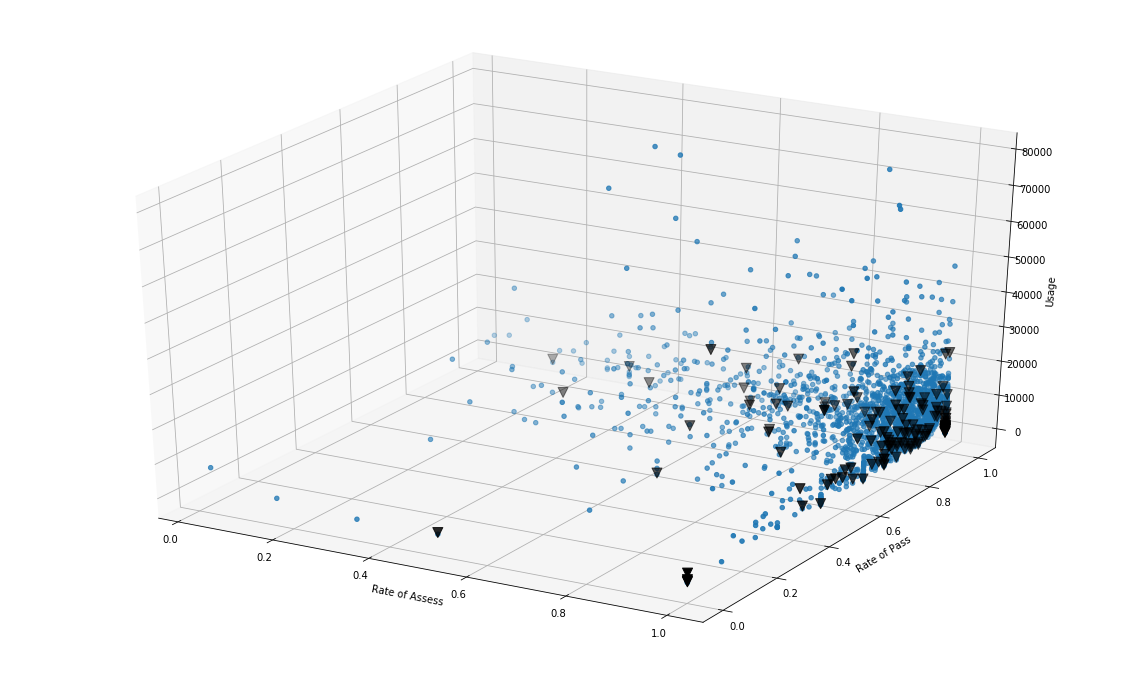

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nonchurner.rate_assess, nonchurner.rate_pass, nonchurner.usage)
ax.scatter(churner.rate_assess, churner.rate_pass, churner.usage, marker='v', s=100, c='k')
ax.set_xlabel('Rate of Assess')
ax.set_ylabel('Rate of Pass')
ax.set_zlabel('Usage')

#ax.view_init(elev=10, azim=200)

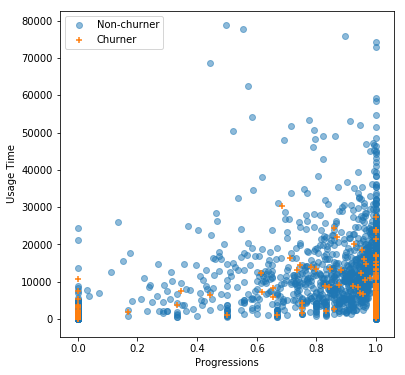

In [16]:
df_agg = pd.DataFrame({'progress': rate_assess, 'usage': usage})

# Identify Churner and non-Churner
pupils_nextMonth = df_subspt1[df_subspt1['customer_month']==(study_month+1)]['pupilId'].unique()
pupils_nextAnnual = df_subspt1[df_subspt1['customer_month']==(study_month+12)]['pupilId'].unique()
pupils_nextMonthRenew = np.union1d(pupils_nextMonth, pupils_nextAnnual)

pupils_thisMonth = df_subspt1[df_subspt1['customer_month']==study_month]['pupilId'].unique()
pupils_nextMonthCancel = np.setdiff1d(pupils_thisMonth, pupils_nextMonthRenew)

df_agg['next_month_cancel'] = 0
df_agg.loc[df_agg.index.isin(pupils_nextMonthCancel), 'next_month_cancel'] = 1

churner = df_agg[df_agg['next_month_cancel']==1]
nonchurner = df_agg[df_agg['next_month_cancel']==0]
####################################################


fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.progress, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.progress, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Progressions')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

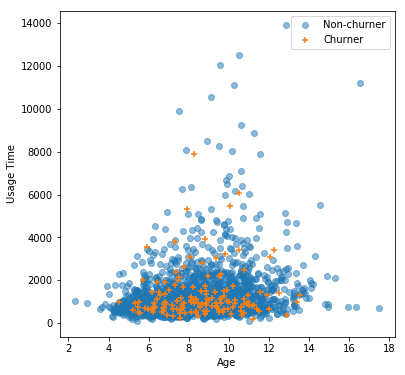

In [8]:

usage_progress = usage / progress

df_agg = pd.DataFrame({'age': age, 'usage': usage_progress})

df_agg['next_month_cancel'] = 0
df_agg.loc[df_agg.index.isin(pupils_nextMonthCancel), 'next_month_cancel'] = 1

churner = df_agg[df_agg['next_month_cancel']==1]
nonchurner = df_agg[df_agg['next_month_cancel']==0]

fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.scatter(nonchurner.age, nonchurner.usage, alpha=0.5, label='Non-churner')
ax.scatter(churner.age, churner.usage, marker='+', label='Churner')
ax.set_xlabel('Age')
ax.set_ylabel('Usage Time')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

In [12]:
from sklearn import linear_model

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


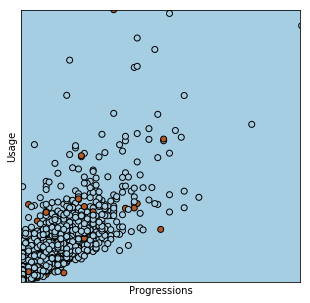

In [13]:
logreg = linear_model.LogisticRegression(C=1)
X = df_agg[['progress', 'usage']]
y = df_agg['next_month_cancel']

logreg.fit(X,y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 100))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Progressions')
plt.ylabel('Usage')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [14]:
import seaborn as sns 

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


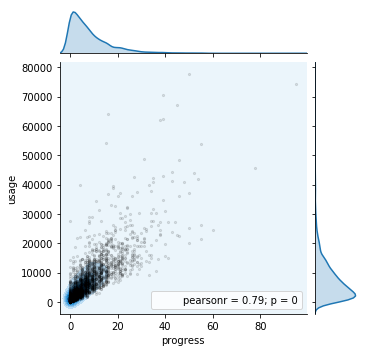

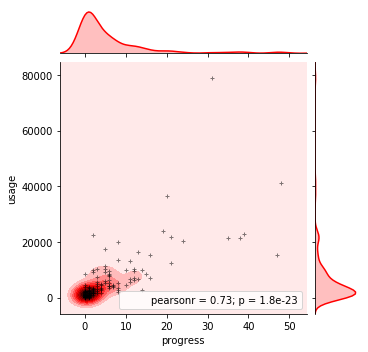

In [23]:
churner = df_agg[df_agg['next_month_cancel']==1]
nonchurner = df_agg[df_agg['next_month_cancel']==0]

g1 = sns.jointplot(x='progress', y='usage', data=nonchurner[['progress', 'usage']], kind='kde', size=5)
g1.plot_joint(plt.scatter, c="k", s=5, linewidth=1, marker="o", alpha=0.1)

g2 = sns.jointplot(x='progress', y='usage', data=churner[['progress', 'usage']], kind='kde', color='r', size=5)
g2.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+", alpha=0.5)

In [6]:
a = pd.DataFrame()

In [7]:
a

""
